In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
# Start and connect to a local H2O cluster
import h2o
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 hours 6 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,"14 days, 14 hours and 52 minutes"
H2O cluster name:,H2O_from_python_gaozhiping_m9096x
H2O cluster total nodes:,1
H2O cluster free memory:,1.623 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [31]:
data = h2o.import_file("sales.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
data["State"] = data["State"].asfactor()
data["Profit"] = data["Profit"]/100000
data.head()

R&D Spend,Administration,Marketing Spend,State,Profit
165349,136898,471784,New York,1.92262
162598,151378,443899,California,1.91792
153442,101146,407935,Florida,1.9105
144372,118672,383200,New York,1.82902
142107,91391.8,366168,Florida,1.66188
131877,99814.7,362861,New York,1.56991
134615,147199,127717,California,1.56123
130298,145530,323877,Florida,1.55753
120543,148719,311613,New York,1.52212
123335,108679,304982,California,1.4976


In [33]:
features = list(data.columns) # we want to use all the information
features.remove('Profit')    # we need to exclude the target 'quality' (otherwise there is nothing to predict)
features

['R&D Spend', 'Administration', 'Marketing Spend', 'State']

In [34]:
# Split the H2O data frame into training/test sets
# so we can evaluate out-of-bag performance
data_split = data.split_frame(ratios = [0.8], seed = 1234)

data_train = data_split[0] # using 80% for training
data_test = data_split[1]  # using the rest 20% for out-of-bag evaluation

In [35]:
data_train.shape

(36, 5)

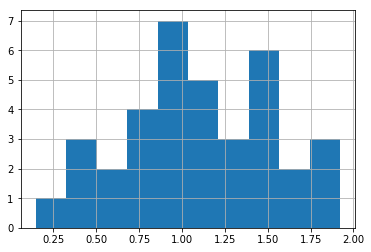

In [36]:
data_train.as_data_frame().Profit.hist()

In [37]:
data_test.shape

(14, 5)

In [38]:
# Build a Gradient Boosting Machines (GBM) model with default settings

# Import the function for GBM
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Set up GBM for regression
# Add a seed for reproducibility
gbm_default = H2OGradientBoostingEstimator(model_id = 'gbm_default', 
                                           seed = 1234)

# Use .train() to build the model
gbm_default.train(x = features, 
                  y = 'Profit', 
                  training_frame = data_train)

# Check the model performance on test dataset
gbm_default.model_performance(data_test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.023914143277526
RMSE: 0.15464198420068853
MAE: 0.1331874060215387
RMSLE: 0.07102560605170356
Mean Residual Deviance: 0.023914143277526


## Sklearn

In [39]:
train_Set = data_train.as_data_frame()
test_Set = data_test.as_data_frame()

In [40]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='error')
st = enc.fit_transform(train_Set['State'].reset_index()).toarray()
st_t = enc.transform(test_Set['State'].reset_index()).toarray()
cols = ['x1_California','x1_Florida','x1_New York']
train_Set = train_Set.drop("State", axis=1)
train_Set[cols] = pd.DataFrame(st, columns=enc.get_feature_names())[cols]
test_Set = test_Set.drop("State", axis=1)
test_Set[cols] = pd.DataFrame(st_t, columns=enc.get_feature_names())[cols]

In [41]:
y_train = train_Set.Profit
X_train = train_Set.drop('Profit', axis=1)
y_test = test_Set.Profit
X_test = test_Set.drop('Profit', axis=1)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [43]:
compare_dic = {}
# Linear Regression
reg1 = LinearRegression()
# Lasso model
parameters = {"alpha" : [i/100 for i in range(0,80,5)]}
reg2 = linear_model.Lasso()
Lasso = GridSearchCV(reg2, parameters, cv = 5)
# Ridge Regression
parameters = {"alpha" : [i/100 for i in range(0,80,5)]}
reg3 = Ridge()
Ridge = GridSearchCV(reg3, parameters, cv = 5)
#Elastic Net
parameters = {"alpha" : [i/100 for i in range(0,80,5)], "l1_ratio":[i/100 for i in range(0,80,5)]}
reg4 = ElasticNet(random_state=0)
Ela = GridSearchCV(reg4, parameters, cv = 5)
#Desition Tree
parameters = {"max_depth" : [30,50,80,15,20,25]}
dt   = DecisionTreeRegressor()
model_dt = GridSearchCV(dt, parameters, cv = 5)
#Random Forest
parameters = {"n_estimators" : [10,50,100,300,350], "max_depth" : [30,56,70,85,10]}
rf   = RandomForestRegressor(random_state=0)
model_RF = GridSearchCV(rf, parameters, cv = 5)

model_list = [reg1, Lasso, Ridge, Ela, model_dt, model_RF]
model_name = ["Linear Regression", "Lasso Regression", "Ridge Regression", "Elastic Net", "Decision Tree", "Random Forest"]
for i in range(len(model_list)):
    model = model_list[i]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    compare_dic[model_name[i]] = mean_squared_error(y_test, pred, )
    print(metrics.mean_squared_error(y_test, pred))

0.008110902229172144
0.006500236721349905
0.00799353732427908
0.006914836970186716
0.014855568978158578
0.011154856914810484


In [15]:
# Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor
import time
parameters = {'max_depth': [3, 5, 7],
             'subsample': [0.7, 0.8, 0.9],
             'max_features':[0.7, 0.8, 0.9]}
gbr   = GradientBoostingRegressor(n_estimators = 10000)
model_gbr = GridSearchCV(gbr, parameters, cv = 5, scoring="neg_mean_squared_error")

start_time = time.time()
model_gbr.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

pred = model_gbr.predict(X_test)
print(metrics.mean_squared_error(y_test, pred))

--- 227.2307357788086 seconds ---
0.009359116135262585


## GBM with CV, Early Stopping and Random Grid Search

In [18]:
from h2o.grid.grid_search import H2OGridSearch

In [19]:
# define the criteria for random grid search
search_criteria = {'strategy': "RandomDiscrete", 
                   'max_models': 9,
                   'seed': 1234}

In [20]:
# define the range of hyper-parameters for grid search
# 27 combinations in total
hyper_params = {'sample_rate': [0.7, 0.8, 0.9],
                'col_sample_rate': [0.7, 0.8, 0.9],
                'max_depth': [2,4,5,7,8,10]}

In [21]:
# Set up GBM grid search
# Add a seed for reproducibility
gbm_rand_grid = H2OGridSearch(
                    H2OGradientBoostingEstimator(
                        model_id = 'gbm_rand_grid', 
                        seed = 1234,
                        ntrees = 10000,   
                        nfolds = 5,
                        stopping_metric = 'mse', 
                        stopping_rounds = 15,     
                        score_tree_interval = 1),
                    search_criteria = search_criteria, # full grid search
                    hyper_params = hyper_params)

In [22]:
# Use .train() to start the grid search
start_time = time.time()
gbm_rand_grid.train(x = features, 
                    y = 'Profit', 
                    training_frame = data_train)
print("--- %s seconds ---" % (time.time() - start_time))

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
--- 10.445855855941772 seconds ---


In [23]:
# Sort and show the grid search results
gbm_rand_grid_sorted = gbm_rand_grid.get_grid(sort_by='mse', decreasing=False)
print(gbm_rand_grid_sorted)

    col_sample_rate max_depth sample_rate  \
0               0.9         5         0.9   
1               0.8         2         0.9   
2               0.9         7         0.9   
3               0.8         7         0.8   
4               0.8         5         0.7   
5               0.9         5         0.7   
6               0.7         2         0.7   
7               0.7         5         0.7   
8               0.7         8         0.8   

                                                        model_ids  \
0  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_6   
1  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_8   
2  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_3   
3  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_4   
4  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_5   
5  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_7   
6  Grid_GBM_py_6_sid_b45e_model_python_1562179094070_6749_model_9 

In [24]:
# Extract the best model from random grid search
best_model_id = gbm_rand_grid_sorted.model_ids[0]
best_gbm_from_rand_grid = h2o.get_model(best_model_id)
best_gbm_from_rand_grid.summary()

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,169.0,169.0,15441.0,1.0,2.0,1.5680473,2.0,3.0,2.5680473


In [25]:
# Check the model performance on test dataset
best_gbm_from_rand_grid.model_performance(data_test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.03470604228791223
RMSE: 0.18629557774652686
MAE: 0.1532355959450063
RMSLE: 0.08642948601161053
Mean Residual Deviance: 0.03470604228791223


In [27]:
# Predict
prediction = best_gbm_from_rand_grid.predict(data_test).as_data_frame()
prediction.columns = ["h2o"]
prediction['sklearn'] = model_gbr.predict(X_test)
prediction["true"] = y_test
prediction["h2o_residual"] = prediction.h2o - prediction.true
prediction["sklearn_residual"] = prediction.sklearn - prediction.true

gbm prediction progress: |████████████████████████████████████████████████| 100%


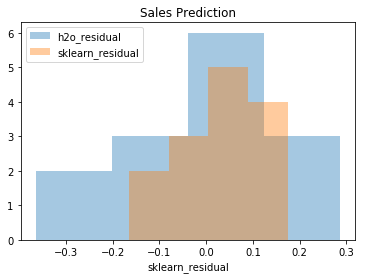

In [28]:
sns.distplot(prediction.h2o_residual,label='h2o_residual', kde=False)
sns.distplot(prediction.sklearn_residual, label='sklearn_residual', kde=False)
plt.title("Sales Prediction")
plt.legend()
plt.show()